In [63]:
# change notes 11/22/24:

# moved data.yaml, model, and dataset locations to LOCAL dir preventing model training path errors
# updated yaml.data to all 10 construction classes to prevent model training IndexError

# added markdowns
# added suggested WIP
# added new datasets link

# added label dir splitting process
# prevented raw_images and raw_labels from being cleared to keep for multiple runs

# trained model from custom labels and construction dataset labels
# added print for model train execution time
# used model to draw bbox instead of function
# added test image and predicted image *from custom dataset*
# cleared runs and predictions for each execution

## Construction+custom dataset (raw_images and raw_labels):

download new contstruction+custom "datasets" folder 
<br>to<u><b> local script directory </u></b> (will be ignored to git):
<br>https://uofsandiego-my.sharepoint.com/:f:/g/personal/dverduzco_sandiego_edu/ErhP9WM76B9Ho2PhSeBd13UB0fADbGPbVfGnB6LPDl_kUw?e=mJiznb

suggested WIP: 
<br><b><u>add dashboard style graphic for business monitoring purposes
<br>add validation loss curves
<br>add live video webcam feed</b></u>

<br>add any further images/ predictions needed
<br>add any further fine tuning on hyperparams
<br>test other models
<br>k-fold cross validation
<br>clean up notebook code, organization of folders/files as needed

# Import Libraries

In [168]:
# import modules
import os # file 
import shutil
import time
import glob
import cv2 # opencv for images
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from ultralytics import YOLO #for obeject detection
import albumentations as A # for image augmentation
from albumentations.pytorch import ToTensorV2 # for image formating
# from tqdm import tqdm  # to show processing progress
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

## Clear the "train", "test", "valid" image folders from "datasets" folder

In [130]:
# create direcories to organize images and cleanup for a new to avoid duplicate images 
def reset_directories(root_dir, directories):
    """
    Check if the specified directories exist. If they do, delete them and recreate them.
    Ensures the directories are clean before use.

    Parameters:
        directories (list): List of directories to reset.
    """
    for path in directories:
        dir_path = root_dir+path
        if os.path.exists(dir_path):
            # delete the directory and all its contents
            try:
                shutil.rmtree(dir_path)
                print(f"Deleted existing directory: {dir_path}")
            except Exception as e:
                print(f"Failed to delete {dir_path}. Reason: {e}")
        
        # Recreate the directory
        try:
            os.makedirs(dir_path, exist_ok=True)
            print(f"Recreated directory: {dir_path}")
        except Exception as e:
            print(f"Failed to create directory {dir_path}. Reason: {e}")
# base dir
dataset_base_dir = "./datasets"

# Define directories to reset
directories_to_reset = [
    "/images/train",
    "/images/valid",
    "/images/test",
    "/labels/train",
    "/labels/valid",
    "/labels/test"
]

# Reset directories
reset_directories(dataset_base_dir, directories_to_reset)

print("Directories reset and ready for use.")

Deleted existing directory: ./datasets/images/train
Recreated directory: ./datasets/images/train
Deleted existing directory: ./datasets/images/valid
Recreated directory: ./datasets/images/valid
Deleted existing directory: ./datasets/images/test
Recreated directory: ./datasets/images/test
Deleted existing directory: ./datasets/labels/train
Recreated directory: ./datasets/labels/train
Deleted existing directory: ./datasets/labels/valid
Recreated directory: ./datasets/labels/valid
Deleted existing directory: ./datasets/labels/test
Recreated directory: ./datasets/labels/test
Directories reset and ready for use.


## Split into train/valid/test files from "raw_image" and "raw_label" folders
### (NOTE: "./datasets/raw_images" and "./datasets/raw_labels" folders must already contain all images and all labels)

In [131]:
# Set random seed for reproducibility
random.seed(11050)

# source directory containing all raw images and labels
source_image_dir = "./datasets/raw_images"
source_label_dir = "./datasets/raw_labels"

# base directory for the organized dataset
base_dir = dataset_base_dir

image_dirs = {
    "train": os.path.join(base_dir, "images/train"),
    "valid": os.path.join(base_dir, "images/valid"),
    "test": os.path.join(base_dir, "images/test")
}
label_dirs = {
    "train": os.path.join(base_dir, "labels/train"),
    "valid": os.path.join(base_dir, "labels/valid"),
    "test": os.path.join(base_dir, "labels/test")
}

# Ensure directories exist
for dir_path in list(image_dirs.values()) + list(label_dirs.values()):
    os.makedirs(dir_path, exist_ok=True)

# Extract the image files
image_files = [f for f in os.listdir(source_image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

# Create DataFrame with file paths and dataset split assignments
df = pd.DataFrame({"filename": image_files})

# Dynamically split dataset into train, valid, and test
train_size = int(0.7 * len(df))  # 70% for training
valid_size = int(0.2 * len(df))  # 20% for validation
test_size = len(df) - train_size - valid_size  # remaining 10% for testing

train_labels = ["train"] * train_size
valid_labels = ["valid"] * valid_size
test_labels = ["test"] * test_size

# Combine and assign to DataFrame
df["split"] = train_labels + valid_labels + test_labels

# Copy files to respective folders
for _, row in df.iterrows():
    img_file = row["filename"]
    split = row["split"]
    
    # Source paths
    img_src = os.path.join(source_image_dir, img_file)
    label_src = os.path.join(source_label_dir, os.path.splitext(img_file)[0] + ".txt")
    
    # Destination paths
    img_dest = os.path.join(image_dirs[split], img_file)
    label_dest = os.path.join(label_dirs[split], os.path.splitext(img_file)[0] + ".txt")
    
    # Copy image file
    if os.path.exists(img_src):
        shutil.copy(img_src, img_dest)
    
    # Copy corresponding label file
    if os.path.exists(label_src):
        shutil.copy(label_src, label_dest)

# Train YOLOv8 from custom dataset

In [62]:
# Time count
start = time.time()
for i in range(10000000):
    pass
    
# Delete all previous model runs
shutil.rmtree("./runs/", ignore_errors=True)

model = YOLO('yolov8n.pt')
model.train(data='data.yaml', epochs = 30, val = True, agnostic_nms=False, seed=88)

# Time end
end = time.time()
elapsed_seconds = end - start
elapsed_minutes = elapsed_seconds / 60
print(f"Execution time: {elapsed_minutes:.2f} minutes")

Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

train: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\labels\test... 287 images, 

train: New cache created: C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\labels\test.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\labels\valid... 571 images, 3

val: WARNING  C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\valid\004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
val: New cache created: C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\labels\valid.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.478       3.81      1.534        219        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911     0.0403        0.3     0.0818     0.0498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.334      3.374      1.453        194        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.949     0.0478     0.0911     0.0546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      1.368      2.789      1.495        272        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7911      0.911     0.0897      0.131      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.353      2.435      1.475        228        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.393      0.166       0.18     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      1.377      2.244      1.479        204        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7911       0.32       0.25      0.222      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.342      2.095      1.453        325        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911      0.315      0.303      0.248       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.323      2.053      1.467        224        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911       0.34        0.3      0.257      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      1.281      1.924      1.433        267        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:27

                   all        571       7911      0.397      0.312      0.287      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.262      1.879      1.436        286        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7911      0.444       0.33      0.313      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G       1.26      1.755      1.401        274        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.471      0.353       0.35      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.237      1.719      1.408        278        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7911      0.525      0.363      0.369      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.252      1.717      1.402        257        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.482      0.367      0.371      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G       1.21      1.676      1.382        240        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.507      0.388      0.387      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G       1.16      1.594      1.354        227        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.555      0.396       0.41      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.155      1.571      1.347        289        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.604        0.4       0.43      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.154      1.529      1.342        329        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7911      0.562      0.404      0.427      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.146      1.565      1.338        278        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.587      0.417       0.44      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.131      1.485       1.32        208        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.587      0.426      0.449       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.082      1.461      1.299        309        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.604      0.429      0.455      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.088       1.42        1.3        241        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7911      0.607      0.435      0.465      0.253


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      1.142      1.475      1.347        163        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7911      0.627      0.427      0.467      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G       1.11      1.449      1.324        132        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7911      0.624      0.431      0.461      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      1.087      1.385      1.304        135        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7911      0.605      0.446      0.473      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.081      1.368      1.305        172        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911      0.626      0.457      0.489      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      1.062      1.309      1.274        158        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911      0.628      0.458      0.487      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.044      1.296      1.291        226        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911      0.648      0.465      0.499      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.053      1.262      1.281        207        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911       0.67      0.458      0.503      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.037      1.261      1.266        236        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911      0.658      0.469      0.512       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G       1.02      1.243      1.263        185        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911      0.657      0.472      0.513      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.018      1.224      1.261        169        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7911      0.653      0.473      0.515      0.294



30 epochs completed in 0.405 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:20


                   all        571       7911      0.655      0.472      0.515      0.294
               Hardhat        304        722      0.799      0.479      0.565      0.322
                  Mask        236        359      0.795      0.685      0.721      0.456
            NO-Hardhat        303        495      0.741      0.457       0.54      0.266
               NO-Mask        338        674      0.495      0.272      0.279      0.102
        NO-Safety Vest        411        872      0.637      0.423      0.475      0.246
                Person        551       2038      0.721      0.626      0.687      0.459
           Safety Cone        133        741      0.591      0.333      0.337      0.123
           Safety Vest        291        643      0.579      0.476      0.498      0.264
             Machinery        432       1050      0.649      0.671      0.707      0.495
               Vehicle        154        317      0.541      0.303      0.341      0.207
Speed: 0.5ms preproce

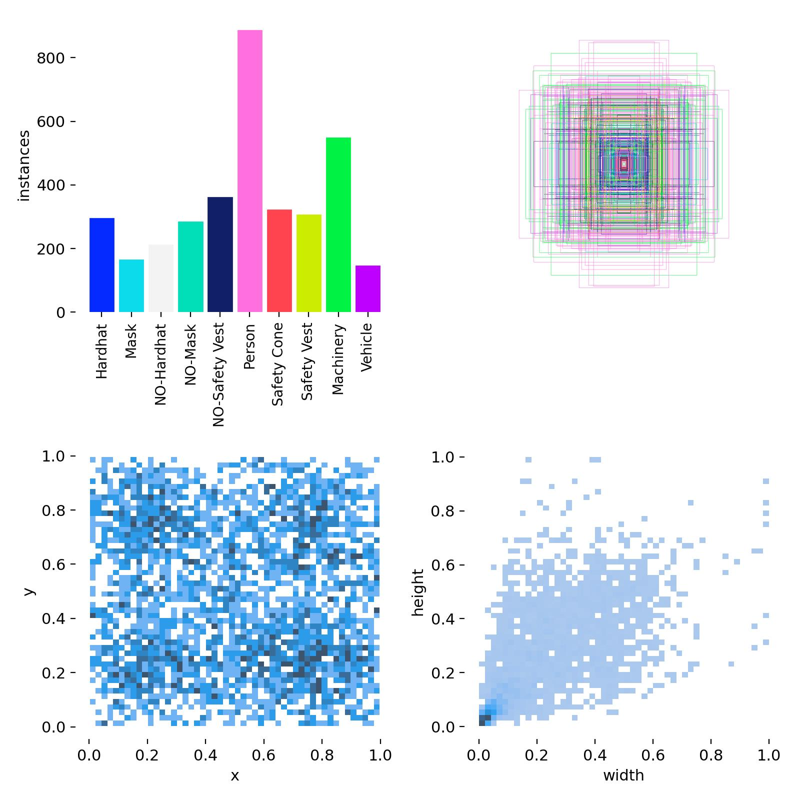

In [64]:
# Show labels diagrams
image_path = "runs/detect/train/labels.jpg"
Image.open(image_path).resize((800,800))

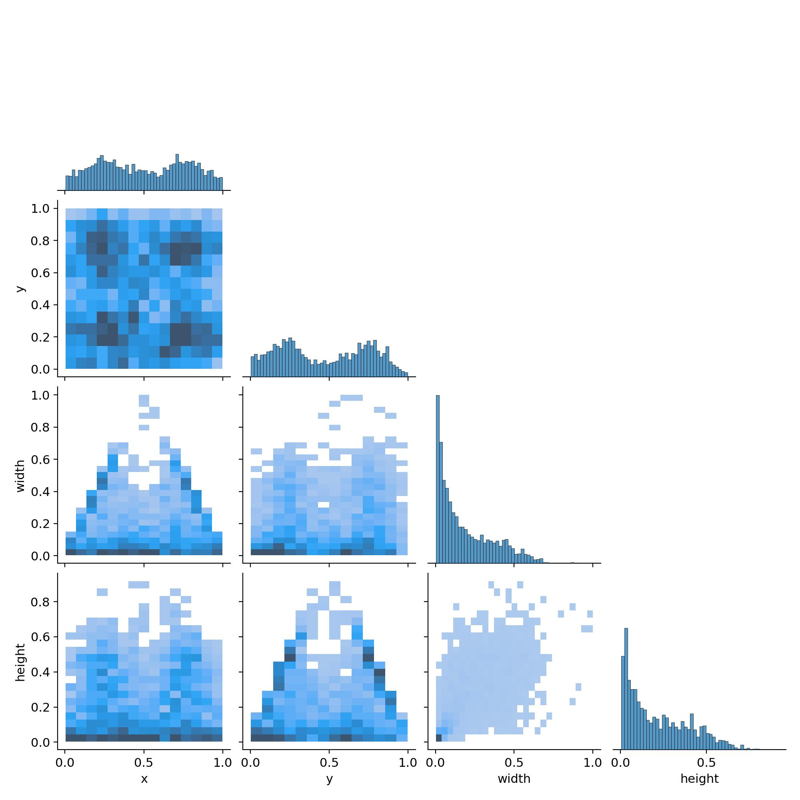

In [7]:
# Show correlogram
image_path = "runs/detect/train/labels_correlogram.jpg"
Image.open(image_path).resize((800,800))

# Custom image from test folder:

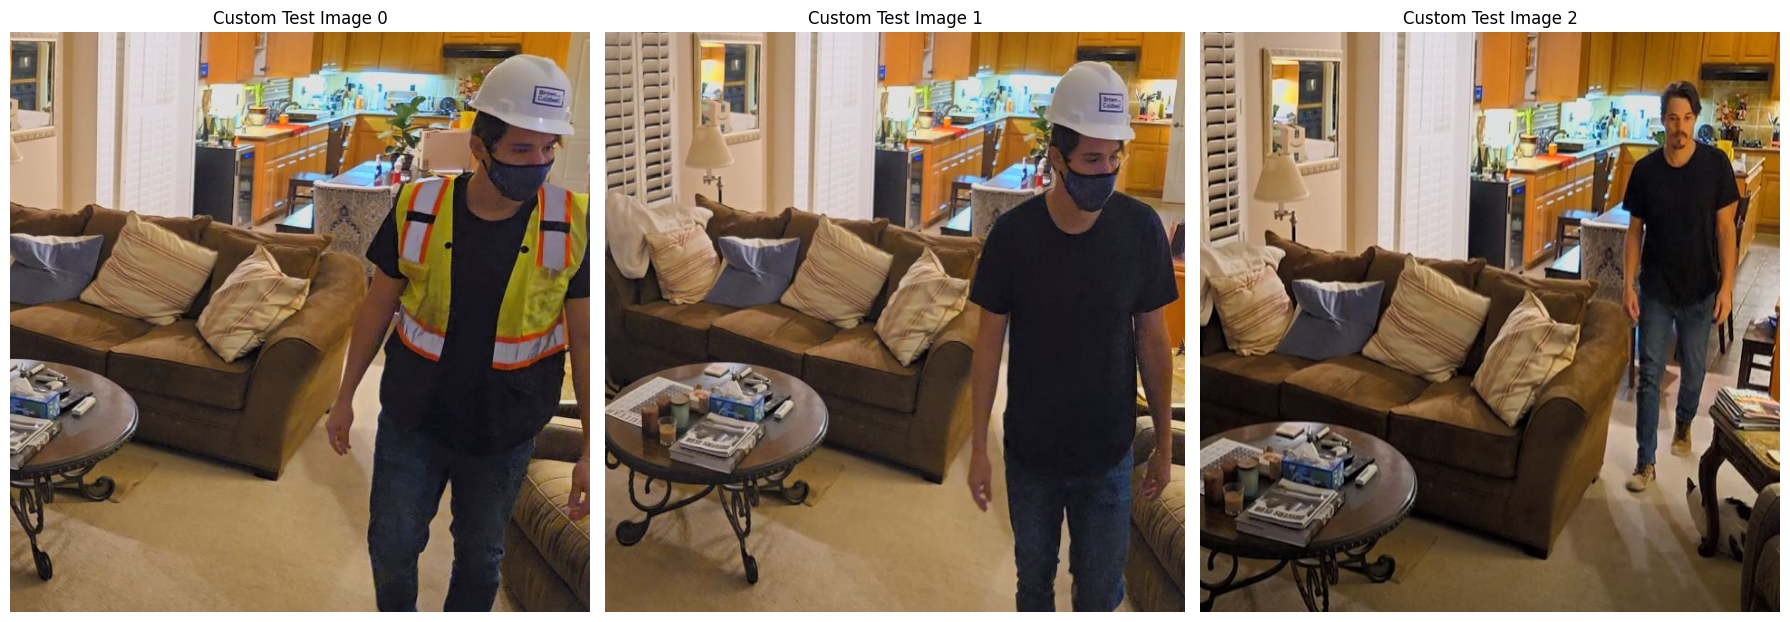

In [180]:
# Get the paths to the first three custom images
image_paths = glob.glob("./datasets/images/test/scene*_*.jpg")[:3]

# Check if there are enough images
if len(image_paths) < 3:
    print("Not enough images found!")
else:
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 7))  # Adjust the figsize as needed

    for i, ax in enumerate(axes):
        # Load and display each image
        image = mpimg.imread(image_paths[i])
        ax.imshow(image)
        ax.axis('off')  # Hide axes
        ax.set_title(f"Custom Test Image {i}")

    plt.tight_layout()
    plt.show()

# Predict with fine tuned model (best.pt)

In [164]:
# Remove previous predictions
# Path to the detect folder
detect_path = "./runs/detect/"
# Iterate through subdirectories and delete folders starting with "predict"
for folder in os.listdir(detect_path):
    folder_path = os.path.join(detect_path, folder)
    if os.path.isdir(folder_path) and folder.startswith("predict"):
        shutil.rmtree(folder_path, ignore_errors=True)

# model = runs/detect/train/weights/best.pt
model = YOLO("runs/detect/train/weights/best.pt")

# Run inference on any custom image in the test folder
model.predict("./datasets/images/test/scene*_*.jpg", save=True, imgsz=640, conf=0.45, agnostic_nms=True, iou=0.7)


image 1/4 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\test\scene1_all_2.jpg: 640x640 1 Hardhat, 1 Person, 1 Safety Vest, 41.8ms
image 2/4 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\test\scene1_hatmask_2.jpg: 640x640 1 Hardhat, 1 NO-Safety Vest, 1 Person, 38.4ms
image 3/4 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\test\scene1_none_1.jpg: 640x640 1 NO-Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 40.0ms
image 4/4 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\test\scene3_none_5.jpg: 640x640 1 NO-Hardhat, 1 NO-Safety Vest, 1 Person, 36.9ms
Speed: 1.7ms preprocess, 39.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'Machinery', 9: 'Vehicle'}
 obb: None
 orig_img: array([[[138, 158, 189],
         [136, 157, 188],
         [132, 156, 186],
         ...,
         [103, 146, 173],
         [104, 144, 172],
         [104, 144, 172]],
 
        [[140, 160, 191],
         [137, 158, 189],
         [132, 156, 186],
         ...,
         [104, 147, 174],
         [105, 145, 173],
         [104, 144, 172]],
 
        [[140, 161, 189],
         [137, 159, 187],
         [129, 153, 183],
         ...,
         [105, 145, 173],
         [104, 145, 170],
         [103, 144, 169]],
 
        ...,
 
        [[ 58, 100, 129],
         [ 58, 100, 129],
         [ 57,  99, 128],
         ...,
         [ 33,  32,  41],
         [ 40,  39,  4

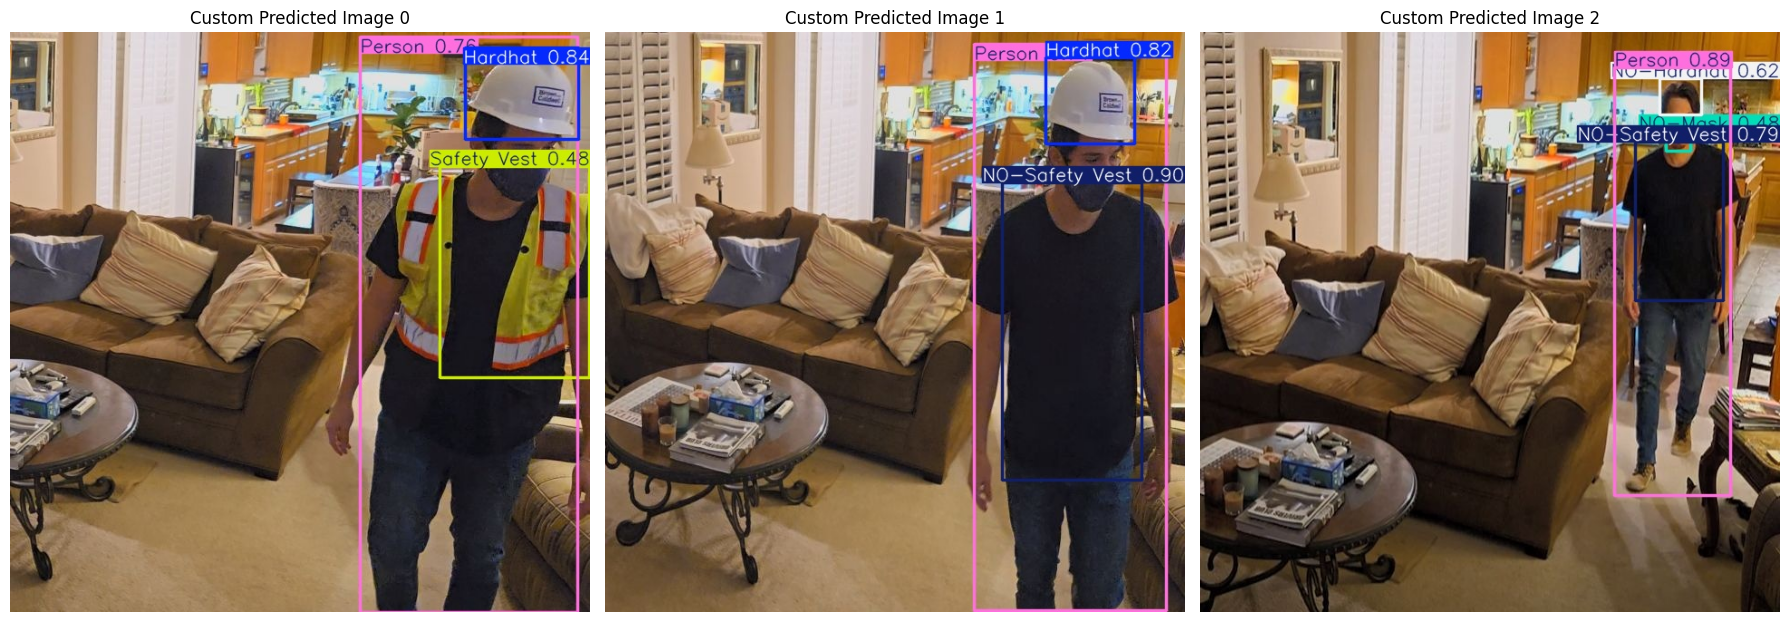

In [179]:
# Get the paths to the first three custom images
image_paths = glob.glob("./runs/detect/predict/scene*_*.jpg")[:3]

# Check if there are enough images
if len(image_paths) < 3:
    print("Not enough images found!")
else:
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 7))  # Adjust the figsize as needed

    for i, ax in enumerate(axes):
        # Load and display each image
        image = mpimg.imread(image_paths[i])
        ax.imshow(image)
        ax.axis('off')  # Hide axes
        ax.set_title(f"Custom Predicted Image {i}")

    plt.tight_layout()
    plt.show()